In [1]:
import folium
import branca
import numpy as np
import pandas as pd
from MoviaBusDataset import MoviaBusDataset
import matplotlib.pyplot as plt

In [2]:
prev_timesteps = 0
prediction_steps = 0

train = MoviaBusDataset('../data/train', 
                        interpolation=True,
                        max_future_time_steps=prediction_steps,
                        timeofday=True,
                        agg_time=10)
test = MoviaBusDataset('../data/test', 
                       interpolation=True,
                       max_future_time_steps=prediction_steps,
                       timeofday=True,
                       agg_time=10)
train = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
test = pd.concat(test.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})

train_all = train.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

test_org = test.pivot(index='Time', columns='LinkRef',values='Speed')

n_testdays = 5
n_measure = int(len(test_org)/5)

testday1 = test_org[0:n_measure].groupby(['TimeOfDay']).mean()
testday2 = test_org[n_measure:2*n_measure].groupby(['TimeOfDay']).mean()
testday3 = test_org[2*n_measure:3*n_measure].groupby(['TimeOfDay']).mean()
testday4 = test_org[3*n_measure:4*n_measure].groupby(['TimeOfDay']).mean()
testday5 = test_org[4*n_measure:5*n_measure].groupby(['TimeOfDay']).mean()

test_all = test_org.groupby(['TimeOfDay']).mean()#This is the mean for all the test days

In [3]:
MAE1 = abs(testday1-train_all).mean().mean()
MAE2 = abs(testday2-train_all).mean().mean()
MAE3 = abs(testday3-train_all).mean().mean()
MAE4 = abs(testday4-train_all).mean().mean()
MAE5 = abs(testday5-train_all).mean().mean()

print('Mean Absolute Error DAY1: ',MAE1)
print('Mean Absolute Error DAY2: ',MAE2)
print('Mean Absolute Error DAY3: ',MAE3)
print('Mean Absolute Error DAY4: ',MAE4)
print('Mean Absolute Error DAY5: ',MAE5)

print('\nMean of all days: ',sum([MAE1,MAE2,MAE3,MAE4,MAE5])/5)


RMSE1 = np.sqrt(((testday1-train_all)**2).mean().mean())
RMSE2 = np.sqrt(((testday2-train_all)**2).mean().mean())
RMSE3 = np.sqrt(((testday3-train_all)**2).mean().mean())
RMSE4 = np.sqrt(((testday4-train_all)**2).mean().mean())
RMSE5 = np.sqrt(((testday5-train_all)**2).mean().mean())

print('\nRoot Mean Square Error DAY1: ',RMSE1)
print('Root Mean Square Error DAY2: ',RMSE2)
print('Root Mean Square Error DAY3: ',RMSE3)
print('Root Mean Square Error DAY4: ',RMSE4)
print('Root Mean Square Error DAY5: ',RMSE5)

print('\nMean of all days: ',sum([RMSE1,RMSE2,RMSE3,RMSE4,RMSE5])/5)

#Dette er for gennemsnitlig hastigheder for alle testdage 
#MAE_all = abs(test3-train3).mean().mean()
#print('Mean absolute Error for mean of all days: ',MAE_all)

#RMSE for gennemsnitlig hastighed for alle testdage. Heller ikke brugbart 
#RMSE_all = np.sqrt(((test3-train3)**2).mean().mean())
#print('Root Mean Square Error for mean of all days: ',RMSE_all)

Mean Absolute Error DAY1:  1.5968409671594719
Mean Absolute Error DAY2:  1.5908280425761168
Mean Absolute Error DAY3:  1.6055921139942966
Mean Absolute Error DAY4:  1.5190530220115228
Mean Absolute Error DAY5:  1.624864660913483

Mean of all days:  1.5874357613309782

Root Mean Square Error DAY1:  2.1859241330379815
Root Mean Square Error DAY2:  2.174028423758008
Root Mean Square Error DAY3:  2.1994952425069716
Root Mean Square Error DAY4:  2.0800198354846158
Root Mean Square Error DAY5:  2.2403193713571867

Mean of all days:  2.1759574012289526


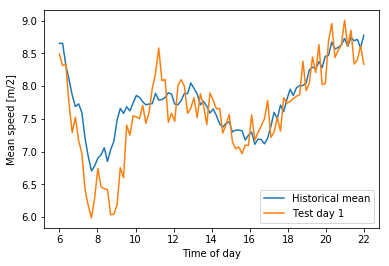

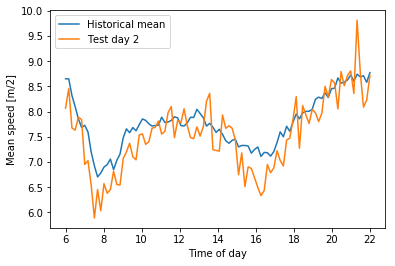

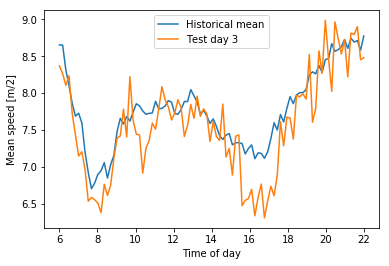

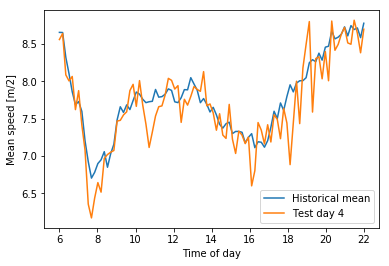

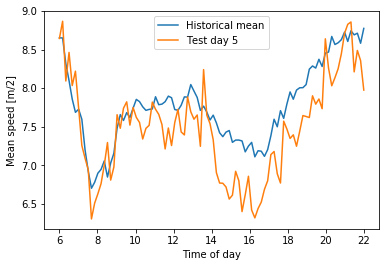

In [4]:
def plot_mean_speed(traindata,testdata,test_legend):
    plt.figure()
    plt.plot(traindata)
    plt.plot(testdata)
    plt.legend(['Historical mean',test_legend])
    plt.xlabel('Time of day')
    plt.ylabel('Mean speed [m/2]')
    
def newTime(data):
    newtime = [6+(22-6)/(len(data)-1)*i for i in range(0,len(data))]       
    #test3.index = [6+(22-6)/192*i for i in range(0,193)]
    return newtime

train_all.index = newTime(train_all)
testday1.index = newTime(testday1)
testday2.index = newTime(testday2)
testday3.index = newTime(testday3)
testday4.index = newTime(testday4)
testday5.index = newTime(testday5)

plot_mean_speed(train_all.mean(1),testday1.mean(1),'Test day 1')
plot_mean_speed(train_all.mean(1),testday2.mean(1),'Test day 2')
plot_mean_speed(train_all.mean(1),testday3.mean(1),'Test day 3')
plot_mean_speed(train_all.mean(1),testday4.mean(1),'Test day 4')
plot_mean_speed(train_all.mean(1),testday5.mean(1),'Test day 5')


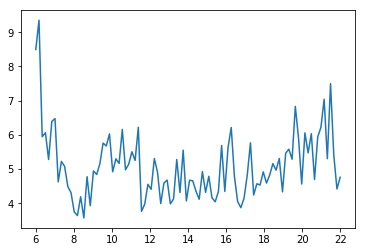

In [5]:
plt.plot(train_all['87502481:4279694295:4279694293'])

In [6]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

linkrefs = train.groupby(['LinkRef']).mean()
linkrefs = [linkref.split(':') for linkref in  linkrefs.index[0:-1].tolist()]
wayID = [linkrefs[i].pop(0) for i in range(len(linkrefs))]
train_all.columns = wayID

In [7]:
#Create two colormaps, one for the mean speed and one for the number of meassurements
cm_mean = branca.colormap.linear.YlOrRd_04.scale(train_all.values.min(),train_all.values.max())

#Create a map object in valby
m = folium.Map(location=[55.66,12.515], zoom_start=15)

#Define two style functions, that change the color depending on the value of the mean speed/count
def style_trafic_mean(feature):
    wayid = feature['properties']['WayId']
    if str(wayid) in wayID:
        val = train_all[str(wayid)].mean()
        if np.size(val) > 1:
            val = val.mean()
        return {
                'fillOpacity': 0.5,
                'weight': 10,
                'color':cm_mean(val)
        }

    else:
        val = 0
        return {
                'fillOpacity': 0,
                'weight': 0,
                'color':0
        }
        
#Add the geojson with colors
g=folium.GeoJson('../data/road_network.geojson',name='mean speed', style_function=style_trafic_mean)
folium.GeoJsonTooltip(['WayId']).add_to(g)
g.add_to(m)
#This is a hack to show a colorbar, and also include all the streets
m.choropleth(geo_data='../data/road_network.geojson'
             , data=train_all.mean(), columns=['LinkRef']
             , key_on='feature.properties.WayId'
             , fill_color='YlOrRd'
             , name='Streets'
             , legend_name='Mean speed [m/s]')
#Add a control layer to our map
folium.LayerControl().add_to(m)

#Show the resulting map
m